<a href="https://colab.research.google.com/github/armiro/canine-disease-diagnosis/blob/main/model_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## libraries and data importing

In [ ]:
# update sklearn package to v0.24.x which is the latest version
!pip install --upgrade scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [3]:
dataset = pd.read_csv("/content/canine_chemical_dataset_v1.6.csv")
print(dataset.head())

features = dataset.iloc[:, :30]
labels = dataset.iloc[:, 30:]

              Species   Age  ... Volume depletion  hepatocellular injury
0       HERDING GROUP  10.0  ...                0                      0
1  NON-SPORTING GROUP  13.0  ...                0                      0
2       WORKING GROUP   1.0  ...                0                      0
3       HERDING GROUP   6.0  ...                0                      0
4       HERDING GROUP   3.0  ...                0                      0

[5 rows x 244 columns]


## EDA: feature correlation detection

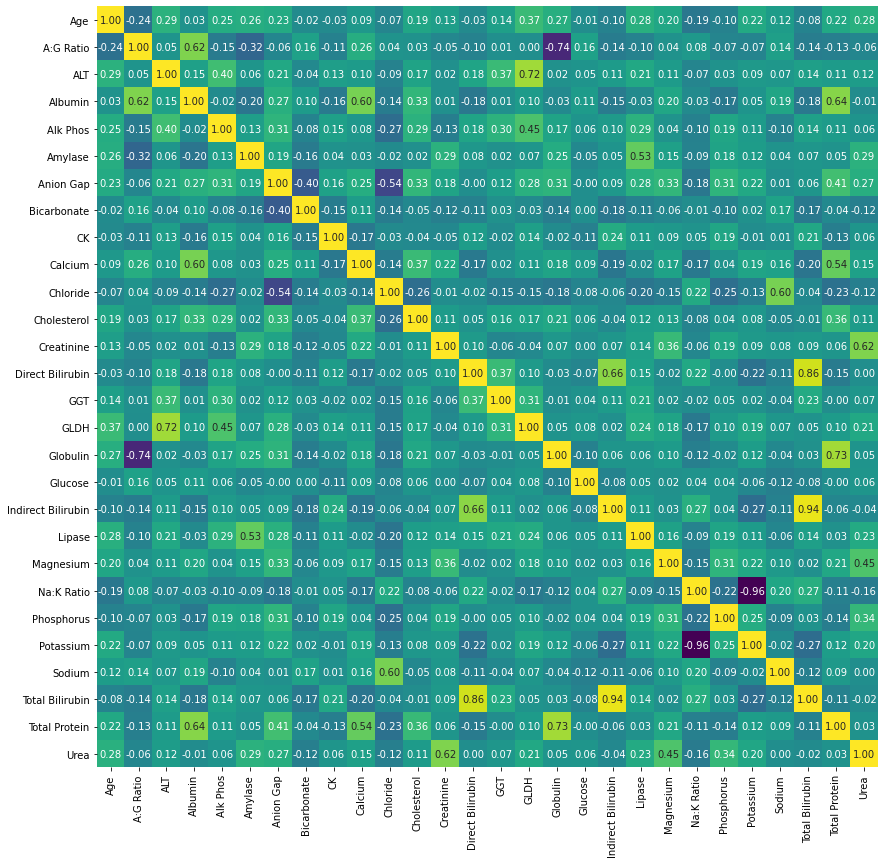

In [ ]:
corr_mat = features.corr()
fig = plt.figure(figsize=(14, 14))
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, 
            cmap='viridis', annot=True, fmt='.2f', cbar=False)

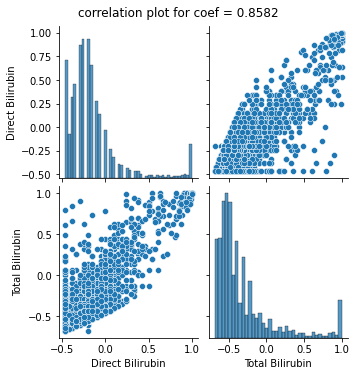

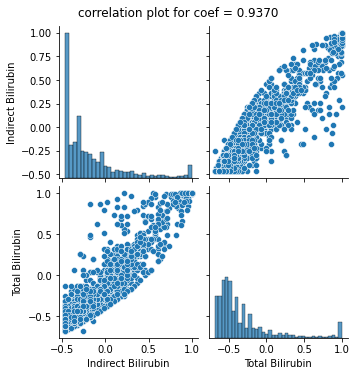

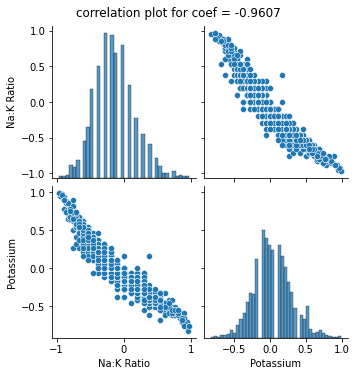

In [ ]:
for r_idx, row in enumerate(corr_mat.values):
    for c_idx, e in enumerate(row[r_idx+1:]):
        if ((e >= 0.8) | (e <= -0.8)) & (r_idx != c_idx):
            plt.rcParams['figure.figsize'] = (5,5)
            sub_df = features[[features.columns[r_idx+2], features.columns[c_idx+r_idx+3]]]
            cp = sns.pairplot(sub_df)
            cp.fig.suptitle("correlation plot for coef = %.4f" % e, y=1.03)
            plt.show()

according to the correlation map, we have some features which have high level of correlations. We must perform feature engineering (dim. reduction using PCA or creating new feature based on correlated ones) on some of the input features

## EDA: label reduction strategies

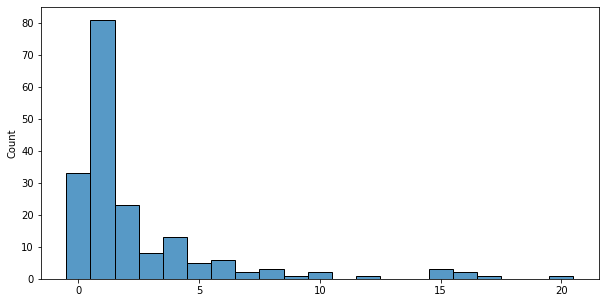

In [4]:
# one last prep step for labels: we have too many (214) labels which could be shrunken
# to much smaller number of labels. we have to let go of labels with few occurances
label_freqs = list()
label_names = list()
for label, column in labels.iteritems():
    label_names.append(label)
    label_freqs.append(np.sum(column))

fig = plt.figure(figsize=(10, 5))
sns.histplot(label_freqs, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

which threshold? we can omit labels with freq < 5 (then change later to see differences). on average, each label is happen 26.5 times.

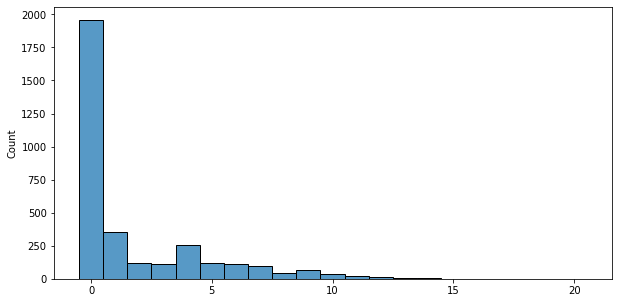

In [5]:
# having labels that never happen (freq = 0) is weird. Let's see how many labels are
# activated for each record
num_activated_labels = list()
for row_idx, row in labels.iterrows():
    num_activated_labels.append(np.sum(row))

fig = plt.figure(figsize=(10, 5))
sns.histplot(num_activated_labels, discrete=True, binrange=(0, 20)) # hist for least frequent
plt.show()

we can see that many records have no activated labels! on average, each record has 1.78 activated labels. Since records with no activated labels mean the canine breed is healthy, we certainly keep these records.
actually, since we have 1958 healthy records out of 3329 samples, we can do a binary disease detection at first and perform disease classification on unhealthy predictions. (hierarchical classification) 

In [ ]:
drop_list = list()
for label, column in labels.iteritems():
    if np.sum(column) < 5: # omit labels with less than 5 occurances
        drop_list.append(label)

labels = labels.drop(columns=drop_list).values
print('number of labels is reduced from %d to %d' % (len(label_names), len(labels[0])))

## final prep & model development

In [6]:
# construct feature transformation pipeline
ct = ColumnTransformer(
    [('onehot_encoder', OneHotEncoder(drop='first', sparse=False), [0, 2]),
     ('standard_scaler', StandardScaler(), [1])],
    remainder='passthrough') # leave other columns untouched
features_encoded = ct.fit_transform(X=features)

In [8]:
# create new label: sick or not?
is_sick = np.array([1.0 if np.sum(row) >= 1 else 0.0 for row in labels.values])

In [33]:
# split the dataset into training-set and test-set
X_train, X_test, y_train, y_test = train_test_split(features_encoded, is_sick, 
                                                    test_size=0.25, random_state=17)

In [ ]:
# perform outlier detection using automated methods

In [39]:
from sklearn.neural_network import MLPClassifier

# class weights?
classifier = MLPClassifier(hidden_layer_sizes=(100, 10,), activation='relu', solver='adam',
                           max_iter=300, verbose=1)

In [ ]:
classifier.fit(X=X_train, y=y_train)

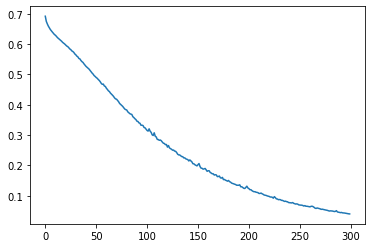

In [41]:
plt.plot(classifier.loss_curve_)
plt.show()

In [42]:
y_pred = classifier.predict(X_test)

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[326, 168],
       [194, 145]])

In [ ]:
# idx = np.random.randint(0, len(X_train))
# print(idx)
# print(classifier.predict(X=np.expand_dims(X_train[idx], axis=0)))
# print(y_train[idx])

## result visualization and discussion

In [ ]:
from sklearn.metrics import confusion_matrix

